In [1]:
# importing pandas
import pandas as pd

In [2]:
# Reading the data into dataframes
companies=pd.read_csv('companies.txt',sep="\t",encoding = "ISO-8859-1")
round2=pd.read_csv('rounds2.csv',encoding = "ISO-8859-1")

In [3]:
#Converting 'found_at' column to datetime
def dtparser(x):
    try:
        return pd.datetime.strptime(x,'%d-%m-%Y')
    except:
        return pd.NaT

companies.founded_at=companies.founded_at.apply(dtparser)

In [4]:
# Converting 'permalink' column in companies and 'company_permalink' column in 
#round2 into upper case so that we can merge them later using these columns
companies.permalink=companies.permalink.apply(lambda x:x.upper())
round2.company_permalink=round2.company_permalink.apply(lambda x:x.upper())

In [5]:
#No of unique companies in companies dataset
unique_companies=companies['permalink'].unique()
print("No. of unique companies in companies.txt is {}".format(len(unique_companies)))

No. of unique companies in companies.txt is 66368


In [6]:
#No of unique compaues in round2
unique_round2=round2['company_permalink'].unique()
print("No. of unique companies in rounds2.csv is {}".format(len(unique_round2)))

No. of unique companies in rounds2.csv is 66370


In [7]:
#Finding the unique key by finding the column with no missing values
unique_key= companies[['permalink','name','homepage_url']].isnull().any()[companies[['permalink','name','homepage_url']].isnull().any()==False].index[0]
print("The column that can be used as unique key in companies.txt is '{}'".format(unique_key))

The column that can be used as unique key in companies.txt is 'permalink'


In [8]:
#Checking if all round2 companies are present in companies.txt
if sum(round2.company_permalink.isin(unique_companies))<len(round2.company_permalink):
    print("Yes, not all companies in rounds2.csv are present in companies.txt")
else:
    print("No, all companies in rounds2.csv are present in companies.txt")

Yes, not all companies in rounds2.csv are present in companies.txt


In [9]:
#Merging the two dataframes using inner merge & doing it on company_permalink
master_frame=pd.merge(round2,companies,how='inner',right_on='permalink',left_on='company_permalink')
master_frame=master_frame.drop(['company_permalink'],axis=1)

print("No of observations present in master_frame are {}".format(len(master_frame)))

No of observations present in master_frame are 114942


In [10]:

#Grouping the median investment size with investment round type
median_by_roundt= master_frame.groupby('funding_round_type')['raised_amount_usd'].median()
average_by_roundt= master_frame.groupby('funding_round_type')['raised_amount_usd'].mean()

#Median for venture, angel, seed, and private equity
median_for_spark_rounds=median_by_roundt.loc[['venture','angel','seed','private_equity']]/10**6
median_for_spark_rounds=median_for_spark_rounds.rename("median_funding (in USD m)")
print(pd.DataFrame(median_for_spark_rounds).apply(lambda x: round(x,2)))

#Average for venture, angel, seed, and private equity
average_for_spark_rounds=average_by_roundt.loc[['venture','angel','seed','private_equity']]/10**6
average_for_spark_rounds=average_for_spark_rounds.rename("average_funding (in USD m)")
print(pd.DataFrame(average_for_spark_rounds).apply(lambda x: round(x,2)))

                    median_funding (in USD m)
funding_round_type                           
venture                                  5.00
angel                                    0.40
seed                                     0.28
private_equity                          20.00
                    average_funding (in USD m)
funding_round_type                            
venture                                  11.75
angel                                     0.96
seed                                      0.72
private_equity                           73.31


In [11]:
#Most suitable investment for Spark funds using 5m to 15m as investment limit
suitable_investment=median_for_spark_rounds[(median_for_spark_rounds>=5)& (median_for_spark_rounds<=15)]
suitable_investment_type=suitable_investment.index[0]
print("The most suitable investment type for Spark funds is {} investment".format(suitable_investment_type))

The most suitable investment type for Spark funds is venture investment


In [12]:
#Grouping the merged_data 'raised_amount_usd' column by country code and summing the values
investment_by_countries=master_frame[(master_frame.funding_round_type==suitable_investment_type)].groupby('country_code')['raised_amount_usd'].sum()/10**6

#Top 9 countries by investment in decresing order and finding top 3 english speaking countries in them
investment_by_countries=investment_by_countries.rename("total_funding (in USD m)")
top9=pd.DataFrame(investment_by_countries.sort_values(ascending=False).apply(lambda x:round(x,2))[:9])
top_countries=top9.index
print(top9)

              total_funding (in USD m)
country_code                          
USA                          422510.84
CHN                           39835.42
GBR                           20245.63
IND                           14391.86
CAN                            9583.33
FRA                            7259.54
ISR                            6907.51
DEU                            6346.96
JPN                            3363.68


In [13]:
#Top 3 English speaking countries
top3_eng=[top_countries[0],*top_countries[2:4]]
for i in range(3):
    print("No {} country for investment is {}".format(i+1,top3_eng[i])) 

No 1 country for investment is USA
No 2 country for investment is GBR
No 3 country for investment is IND


In [14]:
# Reading the mapping.csv data
sectors=pd.read_csv('mapping.csv',encoding = "ISO-8859-1")

#Renaming category_list to primary_sector and replacing '0' with 'na'
sectors=sectors.rename(columns={'category_list':'primary_sector'})
sectors['primary_sector']=sectors['primary_sector'].apply(lambda x:str(x).replace('0','na').lower())

# Finding which main sectors categories belong to
melted_sectors=pd.melt(sectors,id_vars="primary_sector",var_name="main_sector",value_name="id")
mapping_category_main_sectors=melted_sectors[(melted_sectors.id==1)][["primary_sector","main_sector"]]

In [15]:
# Function to strip the main sector from category list column
def prim_sector(x):
    try:
        if x.find('|')!=-1:
            return x[:x.find('|')].lower()
        else:
            return x.lower()
    except:
        return pd.NaT

# Stripping primary sector name from category_list in master_Frame
master_frame["primary_sector"]=master_frame.category_list.apply(prim_sector)

In [16]:
#Merging master frame with the concatinated dataframe 
master_frame=pd.merge(master_frame,mapping_category_main_sectors,how='inner',on='primary_sector')
len(master_frame)

111437

In [17]:
# Creating 3 data frames for funding type and countries 

# Country 1
# Filtering the data frame to the country of interest
D1=master_frame[(master_frame.country_code==top3_eng[0])& (master_frame.funding_round_type==suitable_investment_type)&(master_frame.raised_amount_usd>=5e6)&(master_frame.raised_amount_usd<=15e6)]

In [18]:
# Grouping by main_sector and then aggregating by total dollar raised and count of investments 
D1_group=D1.groupby(['main_sector']).agg({'raised_amount_usd':'sum','main_sector':'count'})

# Renaming the columns in the group object
D1_group=D1_group.rename(columns={'main_sector':'number_inv_main_sector','raised_amount_usd':'total_inv_main_sector'})

# Merging the D2 dataframe created before with group object to get our final dataframe
D1=pd.merge(D1,D1_group,left_on='main_sector',right_index=True,how='inner')

In [19]:
# Finding total number of investments
total_number_investment_1=D1_group.number_inv_main_sector.sum()

# Finding total amount of investments
total_amount_investment_1=D1_group.total_inv_main_sector.sum()

# Finding top sector, second and third-best sector based on count of investments
D1_group=D1_group.sort_values('number_inv_main_sector',ascending=False)
top_sector_count_1=D1_group.index[0]
second_sector_count_1=D1_group.index[1]
third_sector_count_1=D1_group.index[2]

# Counts for top, second-best and third-best sectors in terms of counts
number_investment_top_sector_1=D1_group['number_inv_main_sector'][0]
number_investment_second_sector_1=D1_group['number_inv_main_sector'][1]
number_investment_third_sector_1=D1_group['number_inv_main_sector'][2]

# Top companies in best and second best sectors
top_company_name_1=D1[(D1.main_sector==top_sector_count_1)].groupby('name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
second_company_name_1=D1[(D1.main_sector==second_sector_count_1)].groupby('name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]

print("Total number of investments in {} were {}".format(top3_eng[0],total_number_investment_1))
print("Total amount of investments in {} were {} USD billions ".format(top3_eng[0],round(total_amount_investment_1/10**9,1)))

print("The top sector based on count of investments in {} was '{}'".format(top3_eng[0],top_sector_count_1))
print("The second-best sector based on count of investments in {} was '{}'".format(top3_eng[0],second_sector_count_1))
print("The third-best sector based on count of investments in {} was '{}'".format(top3_eng[0],third_sector_count_1))

print("No of investments in top sector '{}' in {} were {}".format(top_sector_count_1,top3_eng[0],number_investment_top_sector_1))
print("No of investments in second-best sector '{}' in {} were {}".format(second_sector_count_1,top3_eng[0],number_investment_second_sector_1))
print("No of investment in third-best sector '{}' in {} were {}".format(third_sector_count_1,top3_eng[0],number_investment_third_sector_1))

print("The company from country {} and the top sector '{}' based on count of investments which received the highest funding is '{}'".format(top3_eng[0],top_sector_count_1,top_company_name_1))
print("The company from country {} and the second-best sector '{}' based on count of investments which received the highest funding is '{}'".format(top3_eng[0],second_sector_count_1,second_company_name_1))

Total number of investments in USA were 12063
Total amount of investments in USA were 107.8 USD billions 
The top sector based on count of investments in USA was 'Others'
The second-best sector based on count of investments in USA was 'Social, Finance, Analytics, Advertising'
The third-best sector based on count of investments in USA was 'Cleantech / Semiconductors'
No of investments in top sector 'Others' in USA were 2950
No of investments in second-best sector 'Social, Finance, Analytics, Advertising' in USA were 2714
No of investment in third-best sector 'Cleantech / Semiconductors' in USA were 2350
The company from country USA and the top sector 'Others' based on count of investments which received the highest funding is 'Virtustream'
The company from country USA and the second-best sector 'Social, Finance, Analytics, Advertising' based on count of investments which received the highest funding is 'SST Inc. (Formerly ShotSpotter)'


In [20]:
# Country 2

# Filtering the data frame to the country of interest
D2=master_frame[(master_frame.country_code==top3_eng[1])& (master_frame.funding_round_type==suitable_investment_type)&(master_frame.raised_amount_usd>=5e6)&(master_frame.raised_amount_usd<=15e6)]
# Grouping by main_sector and then aggregating by total dollar raised and count of investments 
D2_group=D2.groupby(['main_sector']).agg({'raised_amount_usd':'sum','main_sector':'count'})

# Renaming the columns in the group object
D2_group=D2_group.rename(columns={'main_sector':'number_inv_main_sector','raised_amount_usd':'total_inv_main_sector'})

# Merging the D2 dataframe created before with group object to get our final dataframe
D2=pd.merge(D2,D2_group,left_on='main_sector',right_index=True,how='inner')

# Finding total number of investments
total_number_investment_2=D2_group.number_inv_main_sector.sum()

# Finding total amount of investments
total_amount_investment_2=D2_group.total_inv_main_sector.sum()

# Finding top sector, second and third-best sector based on count of investments
D2_group=D2_group.sort_values('number_inv_main_sector',ascending=False)
top_sector_count_2=D2_group.index[0]
second_sector_count_2=D2_group.index[1]
third_sector_count_2=D2_group.index[2]

# Counts for top, second-best and third-best sectors in terms of counts
number_investment_top_sector_2=D2_group['number_inv_main_sector'][0]
number_investment_second_sector_2=D2_group['number_inv_main_sector'][1]
number_investment_third_sector_2=D2_group['number_inv_main_sector'][2]

# Top companies in best and second best sectors
top_company_name_2=D2[(D2.main_sector==top_sector_count_2)].groupby('name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
second_company_name_2=D2[(D2.main_sector==second_sector_count_2)].groupby('name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]

print("Total number of investments in {} were {}".format(top3_eng[1],total_number_investment_2))
print("Total amount of investments in {} were {} USD billions ".format(top3_eng[1],round(total_amount_investment_2/10**9,1)))

print("The top sector based on count of investments in {} was '{}'".format(top3_eng[1],top_sector_count_2))
print("The second-best sector based on count of investments in {} was '{}'".format(top3_eng[1],second_sector_count_2))
print("The third-best sector based on count of investments in {} was '{}'".format(top3_eng[1],third_sector_count_2))

print("No of investments in top sector '{}' in {} were {}".format(top_sector_count_2,top3_eng[1],number_investment_top_sector_2))
print("No of investments in second-best sector '{}' in {} were {}".format(second_sector_count_2,top3_eng[1],number_investment_second_sector_2))
print("No of investment in third-best sector '{}' in {} were {}".format(third_sector_count_2,top3_eng[1],number_investment_third_sector_2))

print("The company from country {} and the top sector '{}' based on count of investments which received the highest funding is '{}'".format(top3_eng[1],top_sector_count_2,top_company_name_2))
print("The company from country {} and the second-best sector '{}' based on count of investments which received the highest funding is '{}'".format(top3_eng[1],second_sector_count_2,second_company_name_2))

Total number of investments in GBR were 621
Total amount of investments in GBR were 5.4 USD billions 
The top sector based on count of investments in GBR was 'Others'
The second-best sector based on count of investments in GBR was 'Social, Finance, Analytics, Advertising'
The third-best sector based on count of investments in GBR was 'Cleantech / Semiconductors'
No of investments in top sector 'Others' in GBR were 147
No of investments in second-best sector 'Social, Finance, Analytics, Advertising' in GBR were 133
No of investment in third-best sector 'Cleantech / Semiconductors' in GBR were 130
The company from country GBR and the top sector 'Others' based on count of investments which received the highest funding is 'Electric Cloud'
The company from country GBR and the second-best sector 'Social, Finance, Analytics, Advertising' based on count of investments which received the highest funding is 'Celltick Technologies'


In [21]:
# Country 3


# Filtering the data frame to the country of interest
D3=master_frame[(master_frame.country_code==top3_eng[2])& (master_frame.funding_round_type==suitable_investment_type)&(master_frame.raised_amount_usd>=5e6)&(master_frame.raised_amount_usd<=15e6)]
# Grouping by main_sector and then aggregating by total dollar raised and count of investments
D3_group=D3.groupby(['main_sector']).agg({'raised_amount_usd':'sum','main_sector':'count'})

# Renaming the columns in the group object
D3_group=D3_group.rename(columns={'main_sector':'number_inv_main_sector','raised_amount_usd':'total_inv_main_sector'})

# Merging the D3 dataframe created before with group object to get our final dataframe
D3=pd.merge(D3,D3_group,left_on='main_sector',right_index=True,how='inner')

# Finding total number of investments
total_number_investment_3=D3_group.number_inv_main_sector.sum()

# Finding total amount of investments
total_amount_investment_3=D3_group.total_inv_main_sector.sum()

# Finding top sector, second and third-best sector based on count of investments
D3_group=D3_group.sort_values('number_inv_main_sector',ascending=False)
top_sector_count_3=D3_group.index[0]
second_sector_count_3=D3_group.index[1]
third_sector_count_3=D3_group.index[2]


# Counts for top, second-best and third-best sectors in terms of counts
number_investment_top_sector_3=D3_group['number_inv_main_sector'][0]
number_investment_second_sector_3=D3_group['number_inv_main_sector'][1]
number_investment_third_sector_3=D3_group['number_inv_main_sector'][2]

# Top companies in best and second best sectors
top_company_name_3=D3[(D3.main_sector==top_sector_count_3)].groupby('name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]
second_company_name_3=D3[(D3.main_sector==second_sector_count_3)].groupby('name')['raised_amount_usd'].sum().sort_values(ascending=False).index[0]


print("Total number of investments in {} were {}".format(top3_eng[2],total_number_investment_3))
print("Total amount of investments in {} were {} USD billions ".format(top3_eng[2],round(total_amount_investment_3/10**9,1)))

print("The top sector based on count of investments in {} was '{}'".format(top3_eng[2],top_sector_count_3))
print("The second-best sector based on count of investments in {} was '{}'".format(top3_eng[2],second_sector_count_3))
print("The third-best sector based on count of investments in {} was '{}'".format(top3_eng[2],third_sector_count_3))

print("No of investments in top sector '{}' in {} were {}".format(top_sector_count_3,top3_eng[2],number_investment_top_sector_3))
print("No of investments in second-best sector '{}' in {} were {}".format(second_sector_count_3,top3_eng[2],number_investment_second_sector_3))
print("No of investment in third-best sector '{}' in {} were {}".format(third_sector_count_3,top3_eng[2],number_investment_third_sector_3))

print("The company from country {} and the top sector '{}' based on count of investments which received the highest funding is '{}'".format(top3_eng[2],top_sector_count_3,top_company_name_3))
print("The company from country {} and the second-best sector '{}' based on count of investments which received the highest funding is '{}'".format(top3_eng[2],second_sector_count_3,second_company_name_3))

Total number of investments in IND were 328
Total amount of investments in IND were 2.9 USD billions 
The top sector based on count of investments in IND was 'Others'
The second-best sector based on count of investments in IND was 'Social, Finance, Analytics, Advertising'
The third-best sector based on count of investments in IND was 'News, Search and Messaging'
No of investments in top sector 'Others' in IND were 110
No of investments in second-best sector 'Social, Finance, Analytics, Advertising' in IND were 60
No of investment in third-best sector 'News, Search and Messaging' in IND were 52
The company from country IND and the top sector 'Others' based on count of investments which received the highest funding is 'FirstCry.com'
The company from country IND and the second-best sector 'Social, Finance, Analytics, Advertising' based on count of investments which received the highest funding is 'Manthan Systems'


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

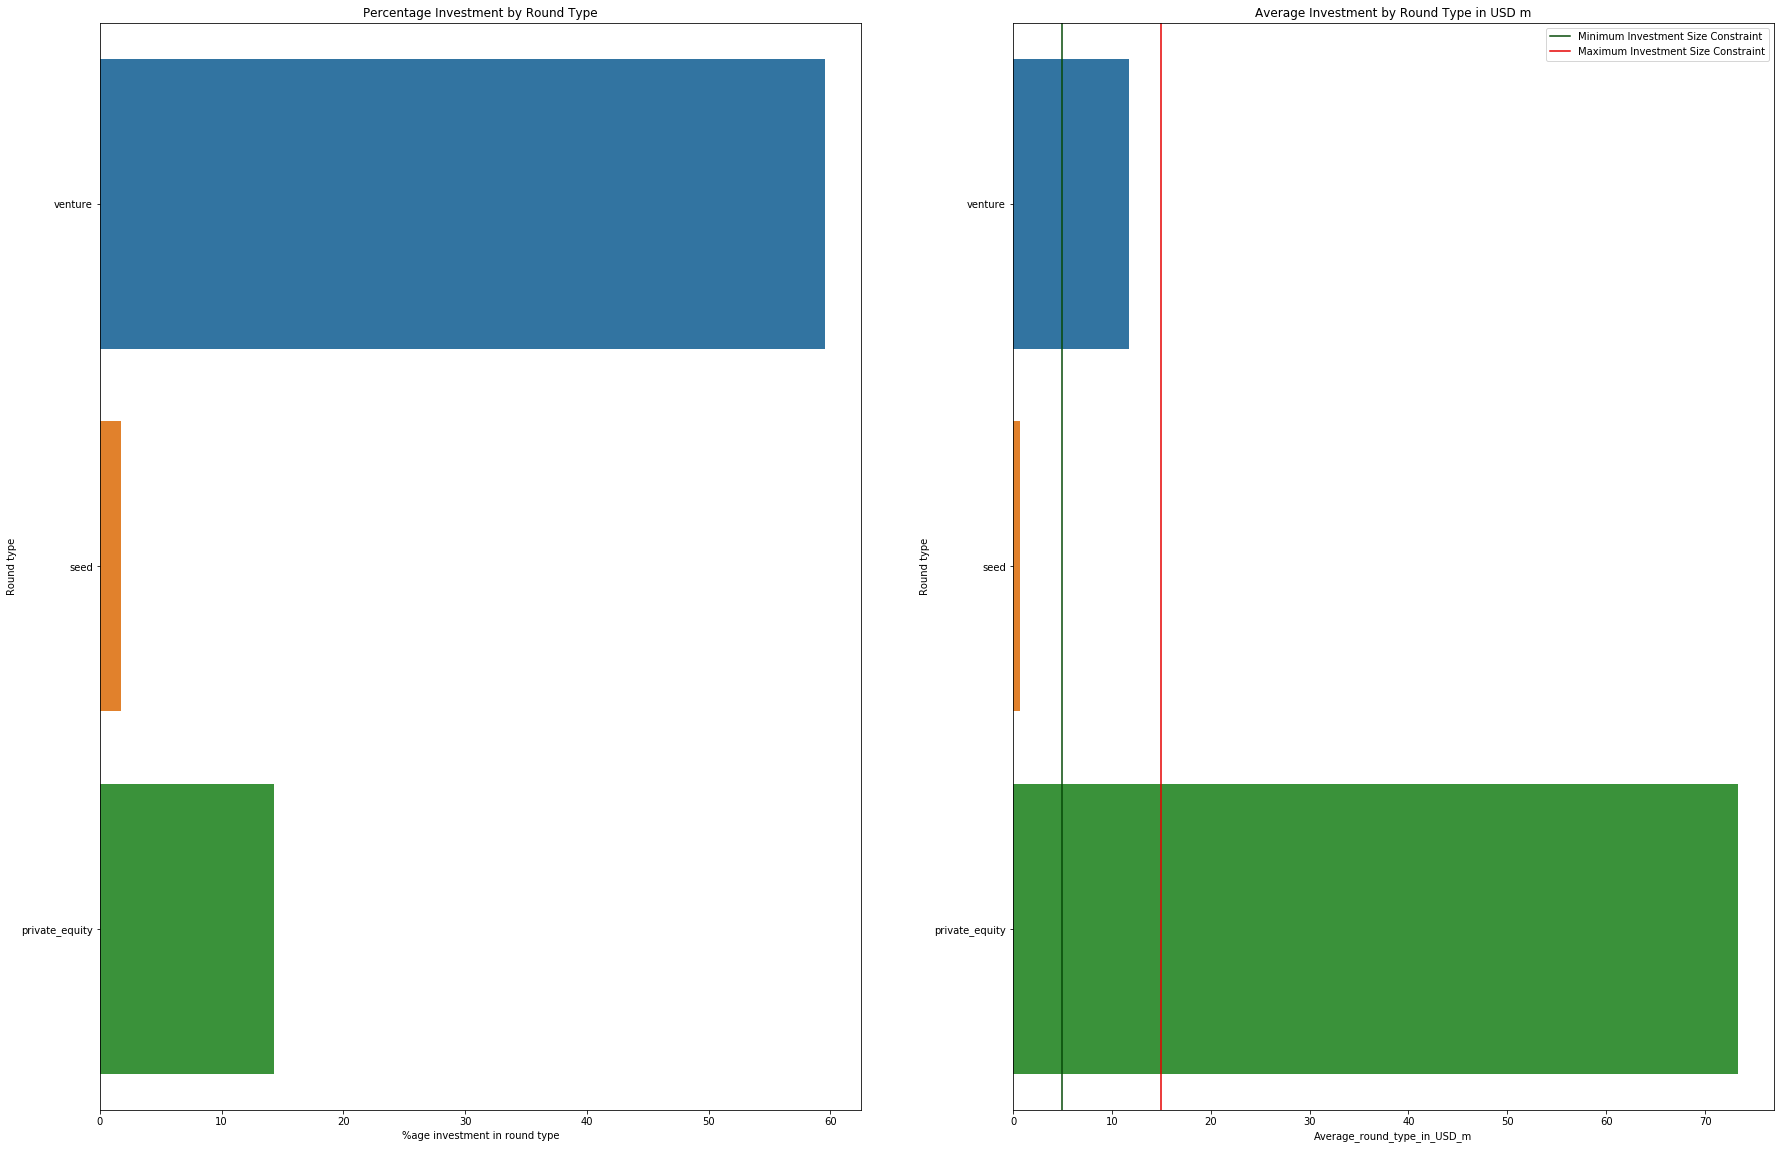

In [23]:
percent_by_roundt= master_frame.groupby('funding_round_type')['raised_amount_usd'].sum()*100/master_frame.raised_amount_usd.sum()
percent_by_roundt= percent_by_roundt.rename('%age_by_round_type')
average_by_roundt= average_by_roundt.rename('average_round_type_in_USD_m')
data1=pd.concat([percent_by_roundt,average_by_roundt/10**6],axis=1).loc[['venture','seed','private_equity']]


# Plot 1
plt.figure(figsize=(30,20))

# First subplot covering the %age investment by round type
plt.subplot(1,2,1)
sns.barplot(x=data1['%age_by_round_type'],y=data1.index)
plt.title('Percentage Investment by Round Type')
# Set x-axis label
plt.ylabel('Round type')
# Set y-axis label
plt.xlabel('%age investment in round type')

# Second subplot covering the average investment in a particular investment type
plt.subplot(1,2,2)
sns.barplot(x=data1['average_round_type_in_USD_m'],y=data1.index)
plt.axvline(x=5,color='xkcd:darkgreen',label='Minimum Investment Size Constraint')
plt.legend(loc='upper right')
plt.axvline(x=15,color='xkcd:red',label='Maximum Investment Size Constraint')
plt.legend(loc='upper right')
plt.title('Average Investment by Round Type in USD m')
# Set x-axis label
plt.ylabel('Round type')
# Set y-axis label
plt.xlabel('Average_round_type_in_USD_m')
plt.show()

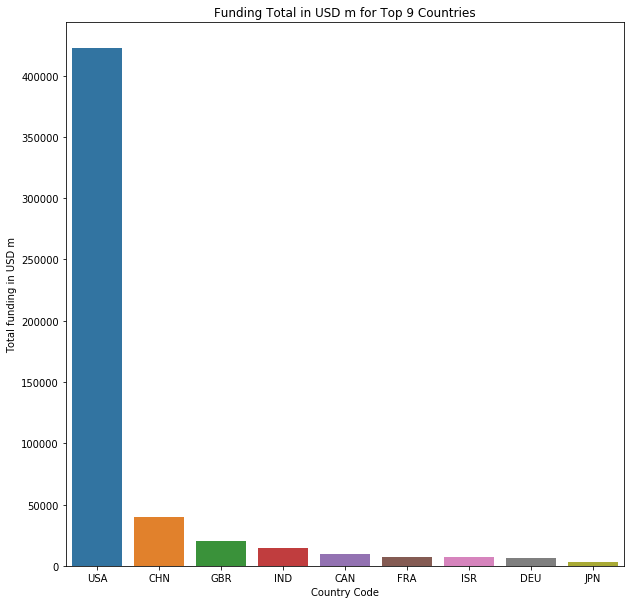

In [24]:
# Plot 2

plt.figure(figsize=(10,10))
sns.barplot(y=top9['total_funding (in USD m)'],x=top9.index)

# Set plot title
plt.title('Funding Total in USD m for Top 9 Countries')
# Set x-axis label
plt.xlabel('Country Code')
# Set y-axis label
plt.ylabel('Total funding in USD m')
plt.show()



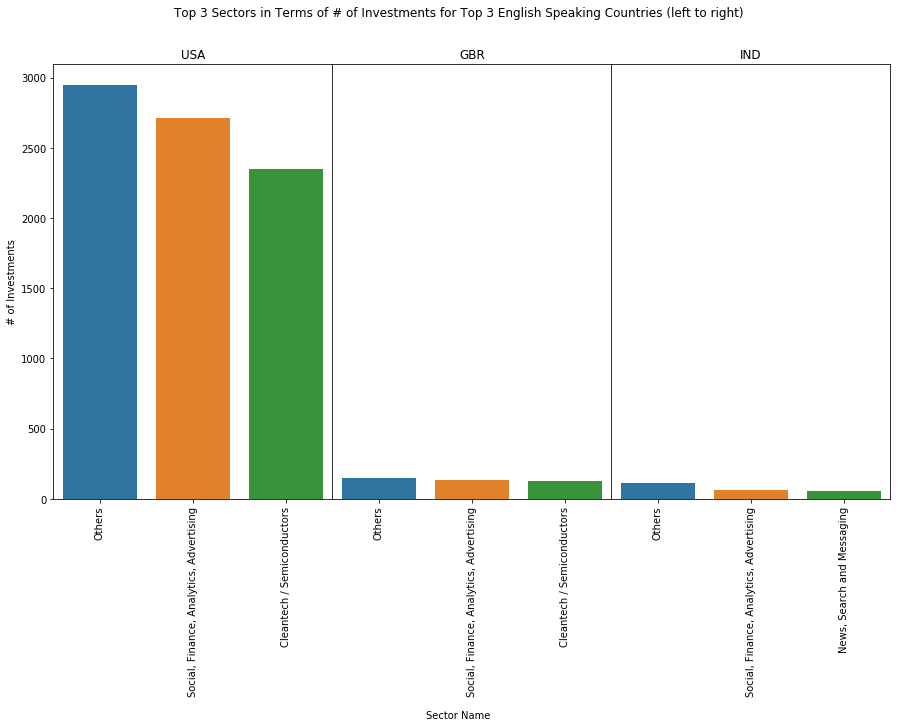

In [91]:
# Plot 3
fig=plt.figure(figsize=(15,8))


# For top English speaking country
plt.subplot(1,3,1)

sns.barplot(x=D1_group.index[:3],y=D1_group['number_inv_main_sector'][:3])
plt.title(top3_eng[0])
plt.ylabel('# of Investments')
plt.ylim(0,max(D1_group['number_inv_main_sector'])*1.05)

plt.xticks(rotation=90)
plt.xlabel('')


# For second-best English speaking country
plt.subplot(1,3,2)

sns.barplot(x=D2_group.index[:3],y=D2_group['number_inv_main_sector'][:3])
plt.title(top3_eng[1])
plt.ylabel('')
plt.yticks([])
plt.ylim(0,max(D1_group['number_inv_main_sector'])*1.05)

plt.xticks(rotation=90)
plt.xlabel('')


# For third-best English speaking country
plt.subplot(1,3,3)

sns.barplot(x=D3_group.index[:3],y=D3_group['number_inv_main_sector'][:3])
plt.title(top3_eng[2])
plt.ylabel('')
plt.yticks([])
plt.ylim(0,max(D1_group['number_inv_main_sector'])*1.05)


plt.xticks(rotation=90)
plt.xlabel('')

# Giving name to the common x-axis as well as the title for the figure 
fig.text(0.5, -0.25, 'Sector Name', ha='center', va='center')
plt.suptitle('Top 3 Sectors in Terms of # of Investments for Top 3 English Speaking Countries (left to right)')
plt.subplots_adjust(wspace=0)

plt.show()
